# Tech Challenge

## Table of contents:
* [Part B](#part-b-bullet)
 * [First Model](#firstmodel-bullet)
 * [Out-of-time Validatation](#outoftime-bullet)
 * [Best Model](#bestmodel-bullet)
 * [Residual Plots](#residual-bullet)
 * [Retention Rate](#retention-bullet)

### Data Preperation <a class="anchor" id="data-bullet"></a>

The input files are list of dictionaries. I make them tabular, store them in a dataframe and export them as and hdf5 files for faster loading.

In [ ]:
# Importing all the necessary modules
import pandas as pd
import numpy as np
import h5py
import ast
import pandas as pd
import matplotlib.pyplot as plt 

In [ ]:
# Path of the input files
"""
/tech_challenge_vlasis_megaritis
/data
/data/forecast_performed.txt
/data/forecast_evaluated.txt
...
"""
path ='data/'

In [ ]:
# I created hdf5 for the forecast_performed.txt, forecast_evaluated.txt, user_activity.txt
files=[ 'forecast_performed','forecast_evaluated','user_activity']
for file in files:
    with open(path+file+".txt", "r") as data:
        dictionary = ast.literal_eval(data.read())  
        df_properties = pd.DataFrame([i['properties'] for i in dictionary])
        df_properties['date'] = pd.to_datetime(df_properties['time'],unit='s')
        df_event = pd.DataFrame([i['event'] for i in dictionary])
        df =pd.concat([df_properties, df_event], axis=1)
        df.rename(columns={0:"events","$distinct_id_before_identity":"distinct_id_before_identity", "insert_id":"insert_id"}, inplace=True)
        store = pd.HDFStore(path+file+".h5")
        df.to_hdf(path+file+".h5", key='forecast_performed', mode='a')
        store.close()

Reading the respective input

In [ ]:
# Reading the files
user_referrer=pd.read_csv(path+"user_referrer.csv") 
user_referee=pd.read_csv(path+"user_referee.csv") 
user_profiles=pd.read_csv(path+"user_profiles.csv")
# Replacing special charachters present in some columns
user_profiles.columns=user_profiles.columns.str.replace('$','')
install_attributed=pd.read_csv(path+"install_attributed.csv") 
forecast_performed=pd.read_hdf(path+'forecast_performed.h5', 'forecast_performed')
forecast_evaluated =pd.read_hdf(path+'forecast_evaluated.h5', 'forecast_evaluated')
user_activity=pd.read_hdf(path+'user_activity.h5', 'user_activity')

Checking for NULL values

In [ ]:
# Finding  null values
print("Forecast Performed")
print(forecast_performed.isnull().sum())
print("=========================================")
print("Forecast Evaluated")
print(forecast_evaluated.isnull().sum())
print("=========================================")
print("User Activity")
print(user_activity.isnull().sum())

Forecast Performed
distinct_id_before_identity    595054
$insert_id                          0
distinct_id                         0
forecast_count                      0
forecast_id                         0
id                                  0
mp_lib                              0
mp_processing_time_ms               0
points                              0
prediction                          0
quote                               0
risk_level                          0
time                                0
date                                0
events                              0
dtype: int64
Forecast Evaluated
distinct_id_before_identity    592078
$insert_id                          0
distinct_id                         0
forecast_id                         0
id                                  0
mp_lib                              0
mp_processing_time_ms               0
points                              0
prediction                          0
quote                               0

We can see that there are no NULL in our main datasets (apart from $distinct_id_before_identity)

It will be interesting to see when our time series starts and ends

In [ ]:
# Print the first and last time of each data
print("Max date of forecast_performed is --", forecast_performed.date.min(),"-- while min date is --", forecast_performed.date.max() )
print("Max date of forecast_evaluated is --", forecast_evaluated.date.min(),"-- while min date is --", forecast_evaluated.date.max() )
print("Max date of user_activity is --", user_activity.date.min(),"-- while min date is --", user_activity.date.max() )

Max date of forecast_performed is -- 2019-03-25 16:28:20 -- while min date is -- 2019-11-07 10:09:49
Max date of forecast_evaluated is -- 2019-03-26 16:28:22 -- while min date is -- 2019-11-07 10:13:39
Max date of user_activity is -- 2019-03-25 16:23:13 -- while min date is -- 2019-11-07 10:15:45


Get columns names for forecast_performed, forecast_evaluated, user_activity

In [ ]:
list(forecast_performed.columns)
list(forecast_evaluated.columns)
list(forecast_evaluated.columns)

['distinct_id_before_identity',
 '$insert_id',
 'distinct_id',
 'forecast_id',
 'id',
 'mp_lib',
 'mp_processing_time_ms',
 'points',
 'prediction',
 'quote',
 'result',
 'risk_level',
 'time',
 'date',
 'events']

Check user_profiles, install_attributed and most popular countries in the dataset

In [ ]:
list(user_profiles.columns)
list(install_attributed.columns)
popular_countries=user_profiles.country_code.value_counts()
popular_countries_by_distinct_id=user_profiles.groupby(['country_code']).size()
print(popular_countries_by_distinct_id.sort_values(ascending=False))

country_code
RU    9297
BR    4452
UA    4278
PH    3835
VN    3828
      ... 
MS       1
FO       1
BQ       1
ML       1
ZW       1
Length: 159, dtype: int64


The countries with the most user profiles are Romania, Brazil, Ukraine, Phillipines, Vietnam and then comes Germany and Switzerland.

## Part B <a class="anchor" id="part-b-bullet"></a>

I will use time series forecasting for predicting the number of active players with a confidence level around it. Specifically a class of models called ARIMA. Information of the past will be used to predict the future. My input will be the number of active clients per day. 

In [ ]:
# Importing all the necessary modules
from statsmodels import *
from numpy import log
import pandas as pd
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
# Use seaborn to make graphs look better
import pmdarima as pm
from pmdarima import *
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

In [ ]:
# Path of the input data
path="data/" 
forecast_performed=pd.read_hdf(path+'forecast_performed.h5', 'forecast_performed')
users_per_day = forecast_performed.groupby([forecast_performed['date'].dt.date]).agg({ "distinct_id": pd.Series.nunique})
users_per_day.rename(columns={'distinct_id': 'value'}, inplace=True)
# I drop the last day since it is not complete
users_per_day.drop(users_per_day.tail(1).index,inplace=True)
df = users_per_day.copy()
df = df.reset_index()
df = df.iloc[3:]
df = df.drop('date', 1)
# Stationarity is important in time series
# If the p value of the ADF test is higher than 0.05 it means that the series is not stationary
adfuller_test = adfuller(df.value)
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])


ADF Statistic: 1.364810
p-value: 0.996948


P-value is 0.996 which means that our series is not stationary. We can also find out by plotting the series.

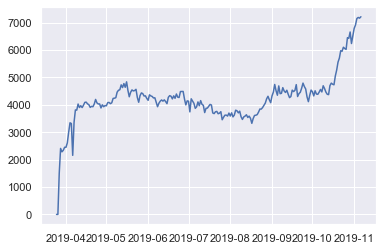

In [ ]:
plt.plot(users_per_day)
plt.show()

We can also see from the graph that there is a certain trend in our series.

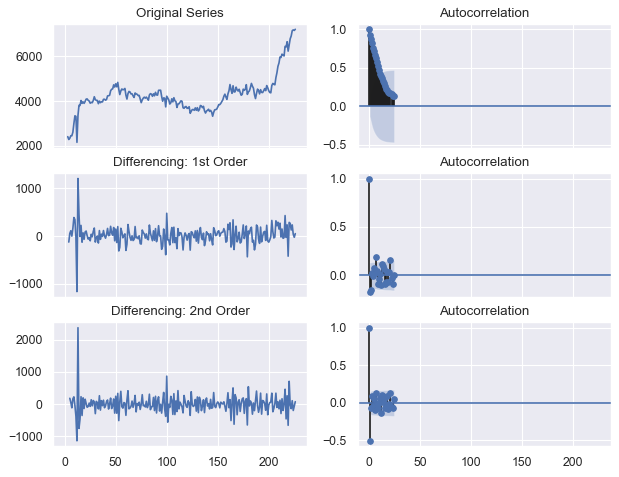

In [ ]:
# We make our series stationary by trying out different order of differencing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':80})
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])
# diff() used to diferrencing first time
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('Differencing: 1st Order')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
# differencing 2nd order
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('Differencing: 2nd Order')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])
plt.show()
plt.close()

### Simple model <a class="anchor" id="firstmodel-bullet"></a>

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
'''
2,1,1 ARIMA Model-fit an ARIMA to the whole dataset
with first order derivative for quick checking
'''
model = ARIMA(df.value, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  223
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1480.334
Method:                       css-mle   S.D. of innovations            184.769
Date:                Tue, 24 Dec 2019   AIC                           2970.669
Time:                        18:24:43   BIC                           2987.705
Sample:                             1   HQIC                          2977.546
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.6912      8.621      2.516      0.013       4.793      38.589
ar.L1.D.value    -0.0248      0.289     -0.086      0.932      -0.591       0.541
ar.L2.D.value    -0.1560      0.087     

The P Values of the AR1 and MA1 terms are above the 0.05 level, which means that there is space for imporvement.

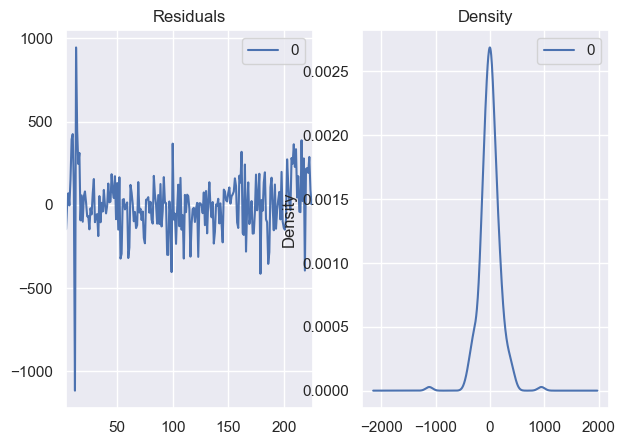

In [ ]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residuals for the most part seem to fluctuate around zero which is good (left). In the density plot (right), the residuals are centered around a mean of zero which is also good.

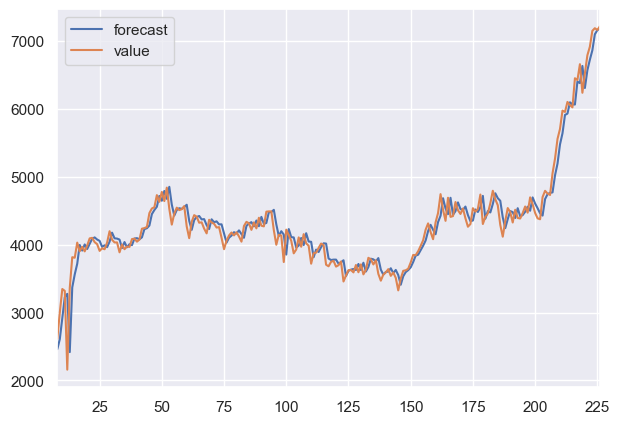

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

Looking at the graph above the forecast seems to be pretty close to the actuals.

### Out-of-time Validation <a class="anchor" id="outoftime-bullet"></a>

We nornally do not train the model on the whole dateset but reserve a sample to see how it performs in observations that it has not seen. I will use a 75:25 split.

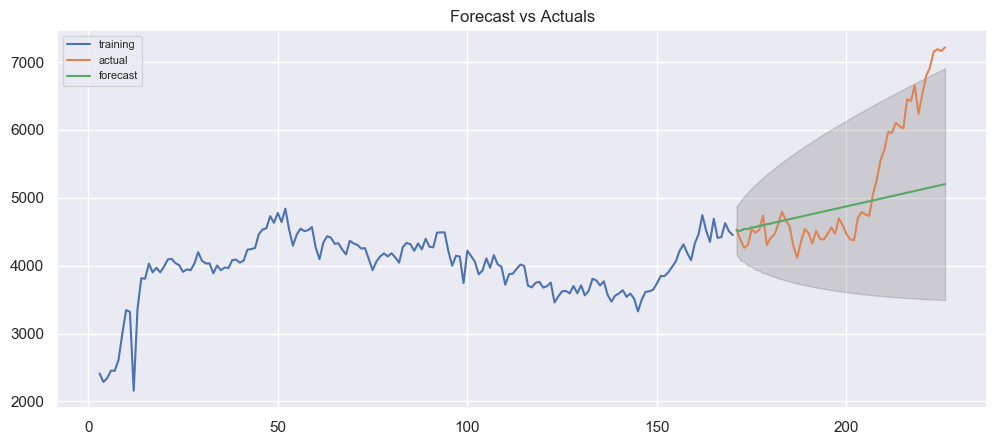

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
# Create Training and Test
train = df.value[:168]
test = df.value[168:]
# Build Model
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
# Forecast
forecast, se, confidence_int = fitted.forecast(56, alpha=0.05)  # 95% conf
# Make as pandas series
forecast_series = pd.Series(forecast, index=test.index)
low_limit = pd.Series(confidence_int[:, 0], index=test.index)
up_limit = pd.Series(confidence_int[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(low_limit.index, low_limit, up_limit, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As seen in the graph above, for the most part of the last 56 days the model performed within the 95 confidence interval. For the first half of the out of sample forecast the model underestimated the actuals and it was obviously not capable to capture the steep spike in the second half part.

Getting the optimal p,d,q parameters for our ARIMA model is crucial. We either have to play around with different combination of parameters or use the auto_arima function. The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. The Akaike Information Critera (AIC) is a widely used measure of a statistical models. On the one hand it quantifies the goodness of fit and on the other the simplicity of the model into a single statistic. When comparing multiple models, the one with the lower AIC is generally better.

In [ ]:
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # for annual non seasonal data
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=2971.401, BIC=2985.030, Fit time=0.231 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=2979.007, BIC=2985.822, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=2974.615, BIC=2984.836, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=2971.436, BIC=2981.658, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=2979.831, BIC=2983.238, Fit time=0.007 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=2970.585, BIC=2987.621, Fit time=0.235 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=2968.867, BIC=2982.495, Fit time=0.028 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=2970.618, BIC=2987.654, Fit time=0.084 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=2972.634, BIC=2993.078, Fit time=0.066 seconds
Total fit time: 0.765 seconds
       

The order order=(2, 1, 0) gives the best model.

### Residual Plots <a class="anchor" id="residual-bullet"></a>

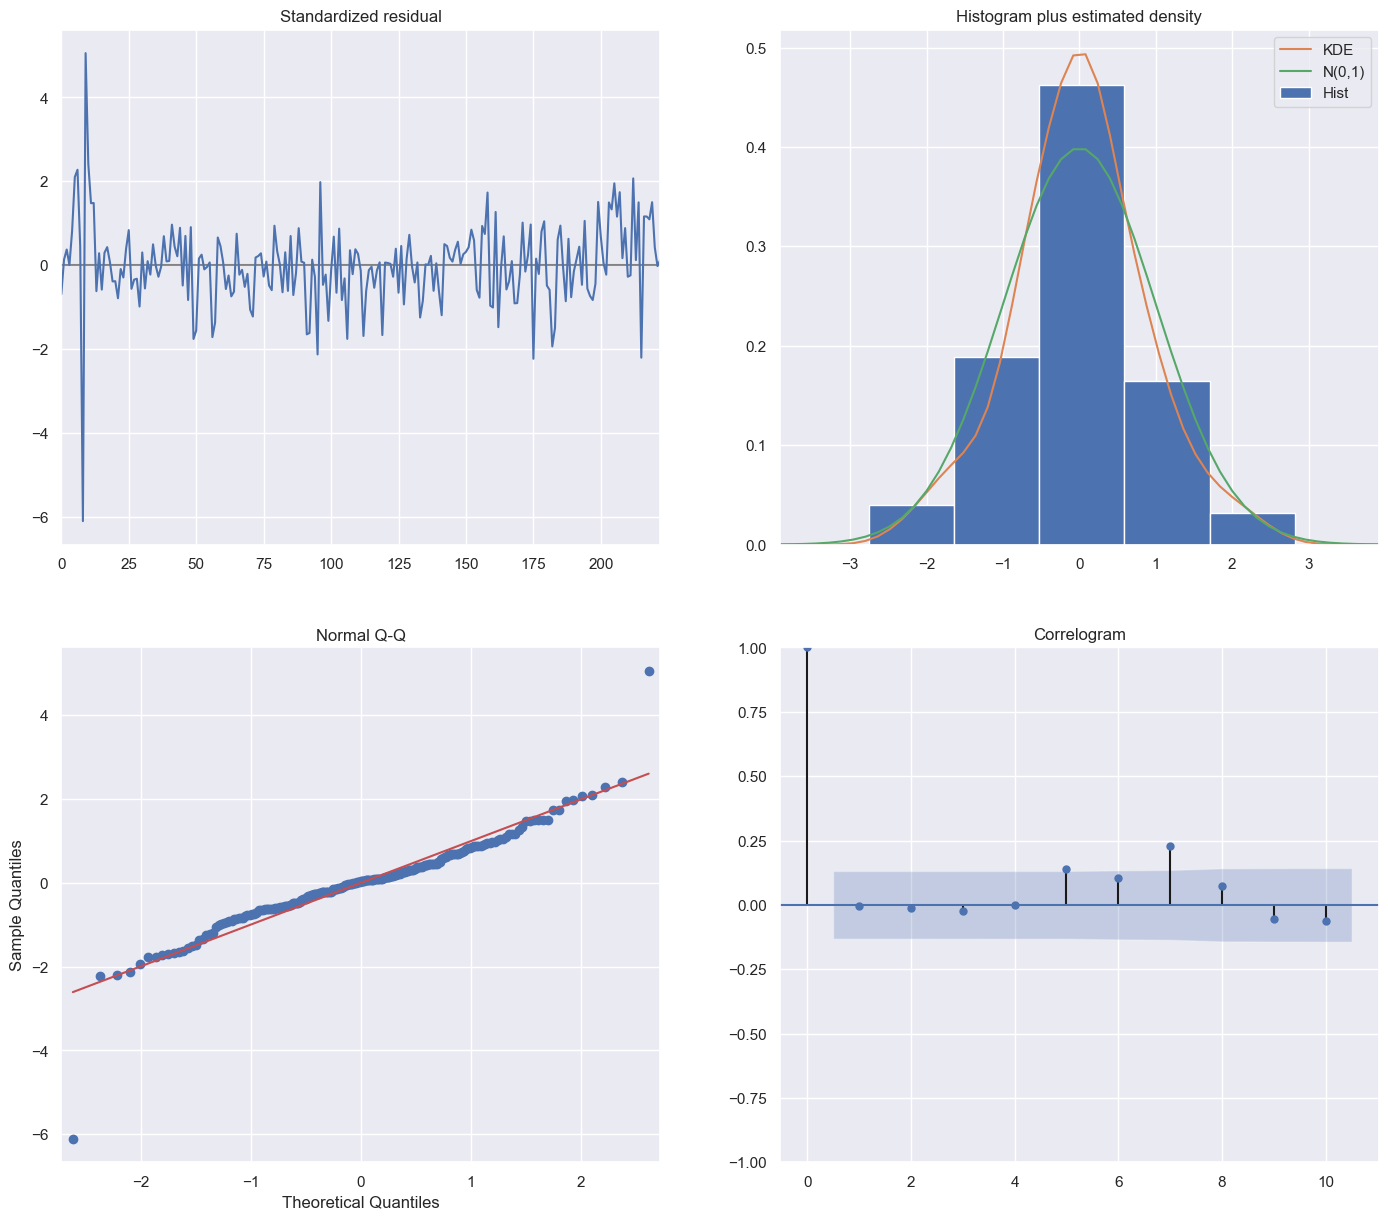

In [ ]:
model.plot_diagnostics(figsize=(17,15))
plt.show()

### Best model <a class="anchor" id="bestmodel-bullet"></a>

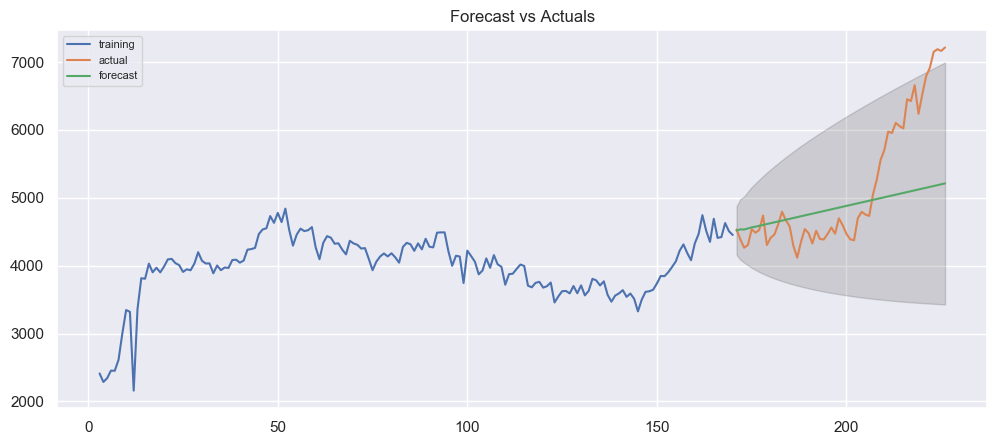

In [ ]:
# Create a test and a train set
train = df.value[:168]
test = df.value[168:]
order=(2, 1, 0)
# Fit the mode
model_final = ARIMA(train, order)  
fitted = model_final.fit(disp=-1)  

# Forecast
forecast, se, conf_interval = fitted.forecast(56, alpha=0.05)  
# The alpha parameter is implying a 95% confidence interval around the prediction

# Make as pandas series
forecast_ser = pd.Series(forecast, index=test.index)
low_interval = pd.Series(conf_interval[:, 0], index=test.index)
up_interval = pd.Series(conf_interval[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_ser, label='forecast')
plt.fill_between(low_interval.index, low_interval, up_interval, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Accuracy metrics <a class="anchor" id="accuracy-bullet"></a>

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


forecast_accuracy(forecast, test.values)
# A mean absolute error of 600 users

{'mape': 0.10327219752254395,
 'me': -288.6522784102079,
 'mae': 600.289550349166,
 'mpe': -0.03279704781564917,
 'rmse': 840.1344222405386,
 'corr': 0.8591387530065788,
 'minmax': 0.10068834566913798}

### Forecast next 12 months <a class="anchor" id="forecast12-bullet"></a>

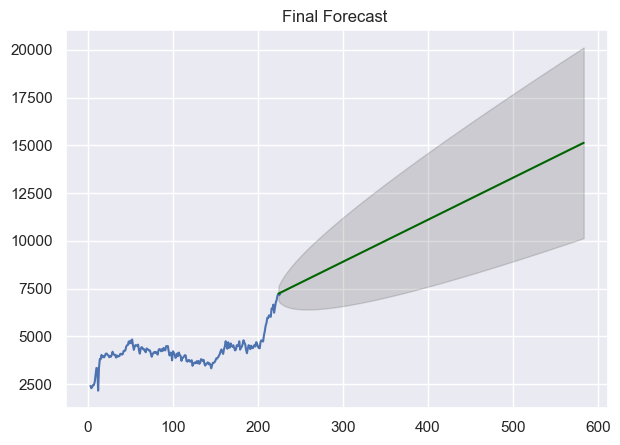

In [ ]:
# We want to forecast for the next
n_periods = 360
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast ")
plt.show()

### Retention rate <a class="anchor" id="retention-bullet"></a>

Cohort analysis is a powerful tool used to measure customer engagement by assigning common attributes to ‘cohorts’ of users.

The first step, is too create a pivot table with the number of players who use the app every month.
The next step is to create the retention rate table, which is variation of the pivot table.

In [ ]:
import datetime as dt
path ='data/'
data=pd.read_hdf(path+'forecast_performed.h5', 'forecast_performed')

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

data['events_month'] = data['date'].apply(get_month)
data['first_month'] = data.groupby('distinct_id')['events_month'].transform('min')

def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

forecast_year, forecast_month, _ = get_date(data, 'events_month')
first_year, first_month, _ = get_date(data, 'first_month')
year_diff = forecast_year - first_year
month_diff = forecast_month - first_month
data['month_index'] = year_diff * 12 + month_diff + 1

In [ ]:
data = data.groupby(['first_month', 'month_index'])['distinct_id'].apply(pd.Series.nunique).reset_index()
cohort_pivot = data.pivot_table(index = 'first_month',
                                       columns = 'month_index',
                                       values = 'distinct_id')
cohort_pivot

month_index,1,2,3,4,5,6,7,8,9
first_month,,,,,,,,,
2019-03-01,4375.0,3395.0,2617.0,2206.0,1867.0,1636.0,1534.0,1390.0,1022.0
2019-04-01,7167.0,3851.0,2837.0,2301.0,1914.0,1697.0,1488.0,1049.0,NaN
2019-05-01,5330.0,2362.0,1677.0,1299.0,1100.0,928.0,630.0,NaN,NaN
2019-06-01,3722.0,1455.0,994.0,804.0,652.0,445.0,NaN,NaN,NaN
2019-07-01,3024.0,1076.0,713.0,588.0,397.0,NaN,NaN,NaN,NaN
2019-08-01,4834.0,1983.0,1309.0,826.0,NaN,NaN,NaN,NaN,NaN
2019-09-01,5073.0,1929.0,1103.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,10321.0,4117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-01,3726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first column in the table above is the distinct players (distinct_id) playing the game on that month and the rest columns show how many of these players remained for following months. So the from the 4375 players that started in March 2019, 3395 kept playing in April. While from the 10321 that started playing the game in October only 4117 continued in November (keep in mind that we don't have data for the whole November in our dataset.

Below I created a heatmap of the retention table.

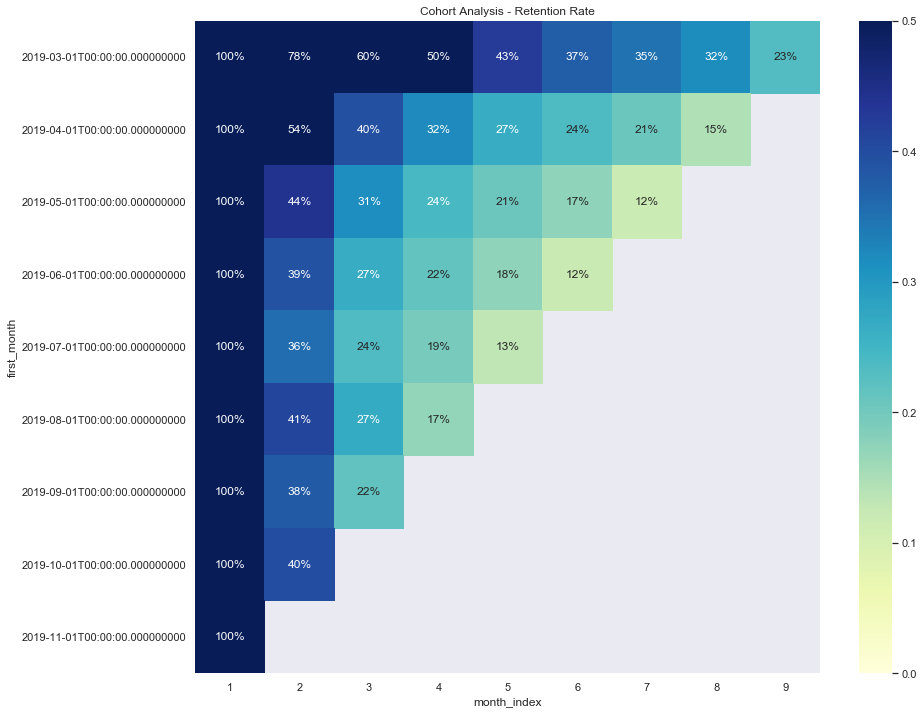

In [ ]:
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis = 0)
retention.round(3) * 100

plt.figure(figsize = (14,12))
plt.title('Cohort Analysis - Retention Rate')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.savefig('/Users/vm/Desktop/cohorts.png')
plt.show()

The heatmap above is a variation of the previously displayed pivot table. The main message that we get is that players in the later months are not so commited to the app as they were in the first months. In most cases there is a greater than 50% decrease of the number of active player from their first month to their second.